# Imports and Downloads

In the following few cells we download all needed files and import all libraries used throughout the notebook

In [1]:
"""Imports and downloads"""
!wget https://nlp.stanford.edu/projects/snli/snli_1.0.zip
!unzip snli_1.0.zip

!python -m spacy download en_core_web_lg

!rm -fr assigntools # helps to rerun this cell witthout errors, if recloning needed 
! git clone https://github.com/kovvalsky/assigntools.git

import spacy
import pickle
import json
import importlib
import assigntools.LoLa.deep_nli
import assigntools.LoLa.read_nli
import assigntools.LoLa.sen_analysis
import nltk
from nltk.corpus import wordnet as wn
importlib.reload(assigntools.LoLa.deep_nli)
importlib.reload(assigntools.LoLa.read_nli)
importlib.reload(assigntools.LoLa.sen_analysis)
from assigntools.LoLa.deep_nli import predict_nli, batch_predict_nli, load_tok_model
from assigntools.LoLa.read_nli import snli_jsonl2dict, sen2anno_from_nli_problems
from assigntools.LoLa.sen_analysis import spacy_process_sen2tok, display_doc_dep
from IPython.display import clear_output
import collections
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
nltk.download('wordnet')
nltk.download('omw-1.4')
import networkx as nx
from pathlib import Path
import logging
from spacy.symbols import VERB, punct, DET, prep, pobj, ADV, AUX, NOUN, acl, nsubj, dobj
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

clear_output()

# Preparing the data

In [2]:
"""Preparing data"""

# SNLI is dict {part: {problem_id: problem_info}}
# S2A is dict {sentence: sentence annotation dict}
SNLI, S2A = snli_jsonl2dict('snli_1.0')
NLP = spacy.load("en_core_web_lg")

SNLI['sub_train'] = { pid: SNLI['train'][pid] for pid in sorted(SNLI['train'])[:10000]}
subtrain_dev_test_S2A = sen2anno_from_nli_problems({**SNLI['sub_train'], **SNLI['dev'], **SNLI['test']}, S2A)
sen2Doc = spacy_process_sen2tok(NLP, { sen: anno['tok'] for sen, anno in subtrain_dev_test_S2A.items()})
clear_output()

# Baseline

In this section we have all the function used for the baseline system

In [57]:
def get_roots_tags(premise, hypothesis):
  """
  Given two sentences return the roots of each together with the tag of each root in the format
  The format of the return sentence is a tuple of  
    - sentence one root token, 
    - sentence one root tag,
    - sentence two root token,
    - sentence two root tag
  """
  roots =  [(tokenP, tokenP.tag_, tokenH, tokenH.tag_) for tokenP in sen2Doc[premise] for tokenH in sen2Doc[hypothesis] \
                      if tokenP.dep_ == "ROOT" and tokenH.dep_ == "ROOT" ]
  return roots[0]

In [58]:
# Thos are the three different sets of tags a root can take on based on previous analyses
# they are separated into three groups - verb tags, subject tags and other tags
verb_set = {'VBG', 'VBZ', 'VBP', 'VBN', 'VBD', 'VB'}
sub_set = {'NN', 'NNS', 'NNP'}
other_set = {'JJ', 'UH', 'MD', 'IN', 'RB', 'RP'}

In [59]:
def same_tag_set(tagP, tagH):
  """
  Given two tags return a boolean if they are in the same tag set
  """
  for s in [verb_set, sub_set, other_set] :
    if tagP in s and tagH in s:
      return True
  return False

In [60]:
def get_subj_children(sub_set, token):
  """
  Given a spacy token this function returns a list of the kids of that token that have a tag from the subject set
  """
  sub = [kid for kid in token.children if kid.tag_ in sub_set]
  return sub

In [61]:
def toCompare(token1, token2):
    """
    Given two Spacy tokens return the determined label
    """
    switch_functions = [True, True, True, True]
    pos = token1.pos_
    token1 = token1.lemma_
    token2 = token2.lemma_

    if token1 == token2:
      return 'entailment'

    if switch_functions[0] == True:
      if antonym(token1, token2, pos):
        return  'contradiction'

    if switch_functions[1] == True:
      if synonym(token1, token2, pos):
          return  'entailment'
    
    if switch_functions[2] == True:
      hyponyms = hyponym_hypernym(token1, token2, pos)
      if hyponyms:
        return 'entailment'
      else:
        return 'neutral'

    if switch_functions[3] == True:
      if co_hyponyms_base(token1, token2, pos):
        return 'contradiction'

    return 'neutral'

In [62]:
def findTokens(premise, hypothesis):
    """
    Given two sentences create word pairs to be compared 
    Where the first generated pair is the root pair and all subsequent are 
    children of the root pairs
    """
    rootPToken, tagP, rootHToken, tagH = get_roots_tags(premise, hypothesis)
    tokens_toCompare = [] # list keeping the roots or the main subjects from both sentences to be compared and their children

    if not same_tag_set(tagP, tagH):
      # If the roots of the premise and hypothesis don't have the same tag 
      if tagP in verb_set and tagH in sub_set:
        # If the premise has a verb root and the hypothesis a subject root
        # we find the premise subject (connected to the verb) and use that instead of the verb 
        subjectsHToken = rootHToken
        subjectsPToken = get_subj_children(sub_set, rootPToken)
        if len(subjectsPToken) != 0 :
          tokens_toCompare = [(subjectsPToken[0], subjectsHToken)]
      elif tagH in verb_set and tagP in sub_set:
        subjectsPToken = rootPToken
        subjectsHToken = get_subj_children(sub_set, rootHToken)
        if len(subjectsHToken) != 0:
          tokens_toCompare = [(subjectsPToken, subjectsHToken[0])]
    else:
      tokens_toCompare = [[rootPToken, rootHToken]]

    childrenP = []
    childrenH = []
    for kid in rootPToken.children:
      childrenP.append(kid)
    for kid in rootHToken.children:
      childrenH.append(kid)
    for i in childrenP:
      for j in childrenH:
        if i.tag_ == j.tag_ and i.pos_ != 'PUNCT':
          tokens_toCompare.append([i, j])

    # If premise is longer than hypothesis
    if len(premise.split()) > 1.15*len(hypothesis.split()):
      grandkidsP = []
      for kidP in childrenP:
        for grandkidP in kidP.children:
          grandkidsP.append(grandkidP)

      for grandkidP in grandkidsP:
        for childH in childrenH:
          if grandkidP.tag_ == childH.tag_ and grandkidP.tag_!='PUNCT' and [grandkidP, childH] not in tokens_toCompare:
            tokens_toCompare.append([grandkidP, childH])
    
    
    # If premise is shorter than hypothesis
    if 1.15*len(premise.split()) < len(hypothesis.split()):  
      grandkidsH = []
      for kidH in childrenH:
        for grandkidH in kidH.children:
          grandkidsH.append(grandkidH) 

      # Compare children premmise to grandchildren hypothesis
      for grandkidH in grandkidsH:
        for childP in childrenP:
          if childP.tag_ == grandkidH.tag_ and childP.tag_!='PUNCT' and [childP, grandkidH] not in tokens_toCompare:
            tokens_toCompare.append([childP, grandkidH])
  
    return tokens_toCompare

In [63]:
def classify_problem(premise, hypothesis): 
  """
  Function that classifies problem pairs from a dataset of the format SNLI
  Returns a list of labels 
  - 
  """
  comparison = findTokens(premise, hypothesis)
  labels_temp = []
  for i in range(len(comparison)):
      labels_temp.append(toCompare(comparison[i][0], comparison[i][1]))
  if len(labels_temp) >= 1:
    if labels_temp[0] == 'contradiction' or 'contradiction' in labels_temp:
      return 'contradiction'
    if labels_temp[0] == "entailment": # because if the previous takes away all the contradictions
      return 'entailment'
    if labels_temp[0] == "neutral"  and len(labels_temp) > 1:
      return collections.Counter(labels_temp[1:]).most_common()[0][0]
  
  return 'neutral'

# Trees

The code in this section contains functions used in creating the Referent Trees and a few examples

In [64]:
def reshapeTree(doc, specify_prepositions=False):
  """
  In:
      doc of a sentence
      specify_prepositions - if True preposition arcs get labels such as 'in'/'over', otherwise the label is always 'preposition'
  Out: nx.DiGraph representing sentence with entities and verbs contracted and arcs simplified
  """
  sent = list(doc.sents)[0]
  tree = nx.DiGraph()
  token_to_node_name = {}
  
  '''Add nodes for entities and generate dict to find them'''
  noun_chunks = sent.noun_chunks
  nc_to_node_name = {}
  chunk_count = 0
  for c in sent.noun_chunks:
    node_name = f"E_{chunk_count}"
    tree.add_node(node_name,lemmas=set(),cat='Entity')
    nc_to_node_name[c] = node_name
    chunk_count += 1
  
  '''Map entity tokens to nodes and add lemmas'''
  for token in sent:
    for nc in sent.noun_chunks:
      if token in nc:
        token_to_node_name[token] = nc_to_node_name[nc]
        if token.pos != DET:
          tree.nodes[token_to_node_name[token]]['lemmas'].add((token.lemma_,token.pos_))
        break

  '''Add verb nodes with lemmas and make dict to find them'''
  verb_count = 0
  for token in (t for t in sent if t.pos == VERB): # ?
    node_name = f"V_{verb_count}"
    verb_count += 1
    tree.add_node(node_name,lemmas=set(),cat='Verb')
    tree.nodes[node_name]['lemmas'].add((token.lemma_,token.pos_))
    token_to_node_name[token] = node_name

  ''''Handle ADV and AUX'''
  def find_verb_ancestor(t,distance=0):
    if t in token_to_node_name and t.pos == VERB:
      return t
    elif t.dep_ == 'ROOT':
      return None
    elif distance >= 5:
      return None
    else:
      d = distance + 1
      return find_verb_ancestor(t.head,d)
  for token in (t for t in sent if t.pos == ADV or t.pos == AUX):
    relevant_verb = find_verb_ancestor(token)
    if relevant_verb:
      token_to_node_name[token]=token_to_node_name[relevant_verb]
      if token.pos == ADV:
        tree.nodes[token_to_node_name[token]]['lemmas'].add((token.lemma_,token.pos_))
    else:
      logging.info(f'SENT: [{doc.text}] - Did not find adverb/aux target. WORD: [{token.text}].')
      

  '''Add prepositions. NOTE: this skips tokens if it does not immediately finds a token that is already mapped (i.e. NOUN/VERB)'''
  def find_mapped_token(t,direction,distance=0):
    if direction == 'UP':
      if t in token_to_node_name:
        return t
      elif t.dep_ == 'ROOT':
        return None
      elif distance >= 5:
        return None
      else:
        d = distance + 1
        return find_mapped_token(t.head,'UP',d)
  def get_pobj(t):
    for c in t.children:
      if c.dep == pobj and c in token_to_node_name:
        return c
    return None

  for token in sent:
    if token.dep == prep:
      preper = find_mapped_token(token,'UP')
      prepee = get_pobj(token)
      if preper and prepee:
        label = ''
        if specify_prepositions:
          label = token.lemma_
        else:
          label = 'preposition'
        tree.add_edge(token_to_node_name[preper],token_to_node_name[prepee],relation=label)
      else:
        logging.info(f'SENT: [{doc.text}] - Did not find both sides of preposition. PREP: [{token.text}].')

  ''''Find root and flip if necessary'''
  for token in sent:
    if token.dep_ == "ROOT":
      if token.pos == VERB:
        if token in token_to_node_name:
          tree.add_edge('ROOT',token_to_node_name[token])
        else:
          logging.info(f'SENT: [{doc.text}] - Root unknown. ROOT: [{token.text}].')
      elif token.pos == NOUN:
        potential_root = None
        for c in token.children:
          if c.dep == acl:
            potential_root = c
            break
        if potential_root:
          if potential_root in token_to_node_name and token in token_to_node_name:
            tree.add_edge('ROOT',token_to_node_name[potential_root])
            tree.add_edge(token_to_node_name[potential_root],token_to_node_name[token],relation='subject')
      break

  '''Find nsubj and dobj relations'''
  for token in sent:
    if token.dep == nsubj or token.dep == dobj:
      if token in token_to_node_name and token.head in token_to_node_name:
        label = ''
        if token.dep == nsubj:
          label = 'subject'
        else:
          label = 'object'
        tree.add_edge(token_to_node_name[token.head],token_to_node_name[token],relation=label)
      else:
        logging.info(f'SENT: [{doc.text}] - Found nsubj or dobj with unmapped tokens. TOK: [{token.text}]. HEAD: [{token.head.text}].')
  
  if not 'ROOT' in tree.nodes:
    logging.info(f'SENT: [{doc.text}] - Could not produce a suitable tree.')
    return None
  return tree

DiGraph with 7 nodes and 5 edges
[('E_0', {'lemmas': {('man', 'NOUN')}, 'cat': 'Entity'}), ('E_1', {'lemmas': {('suit', 'NOUN')}, 'cat': 'Entity'}), ('E_2', {'lemmas': {('gentleman', 'NOUN'), ('other', 'ADJ'), ('two', 'NUM')}, 'cat': 'Entity'}), ('E_3', {'lemmas': {('suit', 'NOUN')}, 'cat': 'Entity'}), ('V_0', {'lemmas': {('run', 'VERB')}, 'cat': 'Verb'}), ('V_1', {'lemmas': {('also', 'ADV'), ('dress', 'VERB')}, 'cat': 'Verb'}), ('ROOT', {})]


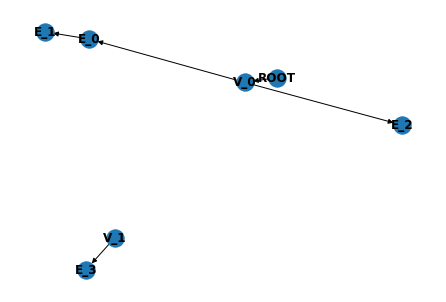

In [65]:
'''Example demonstrating functionality'''
import matplotlib.pyplot as plt

# doc=NLP("Two men in green shirts are standing in a yard.")
# doc = NLP("A man in a red life vest is riding in a canoe.")
doc=NLP("A man in a suit is running past two other gentleman, also dressed in a suit.")
# doc=NLP("A woman with a large purse is walking by a gate.")
display_doc_dep(doc)
tree = reshapeTree(doc)
nx.draw(tree, with_labels=True, font_weight='bold')
print(tree)
print(list(tree.nodes(data=True)))

In [66]:
'''Example demonstrating functionality'''
import matplotlib.pyplot as plt
doc1 = NLP("A closeup of an older man with glasses speaking.")
doc = NLP("An older man is talking.")

# doc=NLP("Two men in green shirts are standing in a yard.")
# doc = NLP("A man in a red life vest is riding in a canoe.")
#doc=NLP("A man in a suit is running past two other gentleman, also dressed in a suit.")
# doc=NLP("A woman with a large purse is walking by a gate.")
#display_doc_dep(doc)
tree1 = reshapeTree(doc1)
tree = reshapeTree(doc)
#nx.draw(tree, with_labels=True, font_weight='bold')
#print(tree)
print(list(tree1.nodes(data=True)))
print(list(tree.nodes(data=True)))

[('E_0', {'lemmas': {('closeup', 'NOUN')}, 'cat': 'Entity'}), ('E_1', {'lemmas': {('old', 'ADJ'), ('man', 'NOUN')}, 'cat': 'Entity'}), ('E_2', {'lemmas': {('glass', 'NOUN')}, 'cat': 'Entity'}), ('V_0', {'lemmas': {('speak', 'VERB')}, 'cat': 'Verb'}), ('ROOT', {})]
[('E_0', {'lemmas': {('old', 'ADJ'), ('man', 'NOUN')}, 'cat': 'Entity'}), ('V_0', {'lemmas': {('talk', 'VERB')}, 'cat': 'Verb'}), ('ROOT', {})]


# Generalize

In this section we have function that we have generalized so we can use them for both the Baseline and the Tree system. 

In [67]:
def antonym(w1, w2, pos):

  contradict = {'sit': ['run', 'walk'], 'play': ['sleep'], 'dog': ['cat'],
  'also': ['alone'], 'so': ['almost'], 'together': ['only'], 'above': ['down'], 'casually': ['inside'],
  'pink': ['blue'], 'yellow': ['red'], 'brown': ['black'],
  'run': ['sit'], 'walk': ['sit'], 'sleep': ['play'], 'cat': ['dog'],
  'alone': ['also'], 'almost': ['so'], 'only': ['together'], 'down': ['above'], 'inside': ['casually'],
  'blue': ['pink'], 'red': ['yellow'], 'black': ['brown']
   }

  w1_word = w1
  w2_word = w2

  for key, val in contradict.items():
    if w1 == key:
      if w2 in val:
        return True

  w2 = wn.synsets(w2)

  if pos == "NOUN":
    w2 = wn.synsets(w2_word, pos = wn.NOUN)
  if pos == "VERB":
    w2 = wn.synsets(w2_word, pos = wn.VERB)

  for ss in w2:
    for lemma in ss.lemmas():
      for antonym in lemma.antonyms():
        if w1_word == antonym.name():
          return True
  return False

def synonym(w1: str, w2: str, pos):

    entaildict = {'run': ['be'], 'ride': ['be'], 'look':['be'], 'be': ['run, ride, look'],
    'dog': ['animal'], 'animal': ['dog'], 'long': ['outdoors'], 'casually': ['outside'], 'almost': ['so', 'heavily', 'inside', 'barely'], 
    'straight': ['outside'], 'outdoors': ['long'], 'outside': ['casually, straight', 'black'], 'so': ['almost'], 'heavily': ['almost'],
    'inside': ['almost'], 'barely': ['almost'], 'gray': ['other'], 'black': ['outside']
      }


    for key, val in entaildict.items():
      if w1 == key:
        if w2 in val:
          return True
  
    synonyms1 = []
    synonyms2 = []

    w1_word = w1
    w2_word = w2

    w1 = wn.synsets(w1)
    w2 = wn.synsets(w2)

    if pos == "NOUN":
      w1 = wn.synsets(w1_word, pos = wn.NOUN)
      w2 = wn.synsets(w2_word, pos = wn.NOUN)
    if pos == "VERB":
      w1 = wn.synsets(w1_word, pos = wn.VERB)
      w2 = wn.synsets(w2_word, pos = wn.VERB)

    for syn in w1:
        for i in syn.lemmas():
            synonyms1.append(syn.name())

    for syn in w2:
        for i in syn.lemmas():
            synonyms2.append(syn.name())

    for w in synonyms1:
      if w in synonyms2:
        return True
        break
    return False

def hyponym_hypernym(w1: str, w2: str, pos):

  neutraldict = { 'sit': ['wait', 'enjoy'], 'stand': ['wait', 'look', 'go'], 'wait': ['sit', 'stand'], 
  'look': ['stand'], 'enjoy': ['sit'], 'go': ['stand'], 'man': ['friend'], 'friend': ['man'], 'man': ['construction'],
  'construction': ['man'], 'young': ['about'], 'brown': ['white'], 'about': ['young'], 'white':['brown']
  }

  for key, val in neutraldict.items():
    if w1 == key:
      if w2 in val:
        return False
  
  w1_word = w1
  w2_word = w2

  w1 = wn.synsets(w1_word)
  w2 = wn.synsets(w2_word)

  if pos == "NOUN":
    w1 = wn.synsets(w1_word, pos = wn.NOUN)
    w2 = wn.synsets(w2_word, pos = wn.NOUN)
  if pos == "VERB":
    w1 = wn.synsets(w1_word, pos = wn.VERB)
    w2 = wn.synsets(w2_word, pos = wn.VERB)
  
  for w in w1:
    for u in w2:
      test = wn.synset(w.name()).lowest_common_hypernyms(wn.synset(u.name()))
      if u in test:
        return True # True if hypothesis is more general than premis
      if w in test:
        return False

def co_hyponyms_base(w1: str, w2: str, pos): # dog and cat
    w1_word = w1
    w2_word = w2

    w1 = wn.synsets(w1_word)
    w2 = wn.synsets(w2_word)

    if pos == "NOUN":
      w1 = wn.synsets(w1_word, pos = wn.NOUN)
      w2 = wn.synsets(w2_word, pos = wn.NOUN)
    if pos == "VERB":
      w1 = wn.synsets(w1_word, pos = wn.VERB)
      w2 = wn.synsets(w2_word, pos = wn.VERB)

    hypernyms1 = []
    hypernyms2 = []

    for syn in w1:
            for i in syn.lemmas():
              for j in syn.hypernyms():
                    hypernyms1.append(j.name())
    for syn in w2:
        for i in syn.lemmas():
          for j in syn.hypernyms():
              hypernyms2.append(j.name())

    for w in hypernyms1:
      if w in hypernyms2:
        return True
        break

    return False

def co_hyponyms_tree(w1: str, w2: str, pos):
    w1_word = w1
    w2_word = w2

    w1 = wn.synsets(w1_word)
    w2 = wn.synsets(w2_word)

    if pos == "NOUN":
      w1 = wn.synsets(w1_word, pos = wn.NOUN)
      w2 = wn.synsets(w2_word, pos = wn.NOUN)
    if pos == "VERB":
      w1 = wn.synsets(w1_word, pos = wn.VERB)
      w2 = wn.synsets(w2_word, pos = wn.VERB)

    if len(w1) > 0 and len(w2) > 0:
      shortest = w1[0].shortest_path_distance(w2[0], simulate_root=False)
      shortest = int(0 if shortest is None else shortest) # convert Nonetype to int
      if shortest <= 3:
        return True

    return False

In [68]:
def compareLemmas(lemma_p, lemma_h):
    res = [] # store labels for the different word pairs
    for i in lemma_p:
      for j in lemma_h: 
        if i[1] == j[1]:   # Check if i[1] and j[1] have the same POS
          pos = i[1]
          switch_functions = [True, True, True, True]

          token_p = i[0]
          token_h = j[0]

          if token_p == token_h:
            res.append('entailment')
            continue

          if switch_functions[0] == True:
            if antonym(token_p, token_h, pos):
              res.append('contradiction')
              continue

          if switch_functions[1] == True:
            if synonym(token_p, token_h, pos):
                res.append('entailment')
                continue
          
          if switch_functions[2] == True:
            hyponyms = hyponym_hypernym(token_p, token_h, pos)
            if hyponyms == False: # premise more general
                res.append('neutral')
                continue
            if hyponyms == True: # hypothesis more general
                res.append('entailment')
                continue

          if switch_functions[3] == True:
            if co_hyponyms_tree(token_p, token_h, pos):
              res.append('contradiction')
              continue

          res.append('neutral')
    
    return res

In [69]:
def compareTrees(tree_p, tree_h):
  '''
  idea
  IN:
      tree p and tree h from the recursion function
  OUT:
      label by using hyponym_hypernym, antonym, and synonym functions in the more_general function
  '''

  edge_p = tree_p.edges(data=True)
  edge_h = tree_h.edges(data=True)

  res = []
  for i in edge_h:
    for j in edge_p:
      if i[1][0] == j[1][0]: # check if the entities are the same
        if i[2] != None and j[2] == None:  # if word in hypothesis but not in premise
          res.append('neutral')
        if i[2] == None and j[2] != None: # if word in premise but not in hypothesis
          res.append('entailment')
        if i[2] == j[2]:
          lemma_h = tree_h.nodes[i[1]]['lemmas'] 
          lemma_p = tree_p.nodes[j[1]]['lemmas'] 
          comparison = compareLemmas(lemma_p, lemma_h)
          for l in comparison:
            res.append(l)

  if 'contradiction' in res:
    return 'contradiction'

  res_temp_set = list(set(res))
  if len(res_temp_set) == 1:
    return res_temp_set[0]

  else:
    return collections.Counter(res).most_common(1)[0][0]

# Results

In [70]:
def system_statistics(dataset : str, level : int) : 
  """
  Given a string dataset - {sub_train, test}
  Calculate the true and predicted labels and print the statistics
  """
  true_labels = []
  pred_labels = []
  trees = 0

  for p in SNLI[dataset] :
    tree_p = reshapeTree(NLP(SNLI[dataset][p]['p']))
    tree_h = reshapeTree(NLP(SNLI[dataset][p]['h']))

    if tree_p and tree_h and level != 0: # If both premise and hypothesis are converted to tree
      true_labels.append(SNLI[dataset][p]['g'])
      pred_labels.append(compareTrees(tree_p, tree_h))
      trees += 1
    elif level != 1: # use baseline system
      true_labels.append(SNLI[dataset][p]['g'])
      pred_labels.append(classify_problem(SNLI[dataset][p]['p'], SNLI[dataset][p]['h']))


  ### --- Print important numbers 
  print("In the test dataset there are {} probelms, \n from which {} can be transformed into trees \n and for {} we have used the baseline system".format(len(SNLI[dataset]), trees, (len(SNLI[dataset])-trees)))
  print("=>> In the true labels there are =>>", collections.Counter(true_labels))
  print("=>> In the predicted labels there are =>>", collections.Counter(pred_labels))

  ### --- Confudion matrices 
  confusion_matrix = metrics.confusion_matrix(true_labels, pred_labels)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['contradiction', 'entailment', 'neutral'])

  #Create normalized Confusion Matrix
  cm_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
  sns.heatmap(cm_normalized, annot=True, linewidths = 0.01)

  cm_display.plot()
  plt.show()

  ### --- Metrics including accuracy, precision, recall and f-score
  print("=>> The accuracy of the dataset {} is {}".format(dataset, accuracy_score(true_labels, pred_labels, normalize=True)))
  print("=>> The precision, recall and f_score are ", precision_recall_fscore_support(true_labels, pred_labels, average='macro')[:3]) 


In the test dataset there are 63 probelms, 
 from which 0 can be transformed into trees 
 and for 63 we have used the baseline system
=>> In the true labels there are =>> Counter({'entailment': 32, 'contradiction': 23, 'neutral': 8})
=>> In the predicted labels there are =>> Counter({'entailment': 43, 'neutral': 16, 'contradiction': 4})


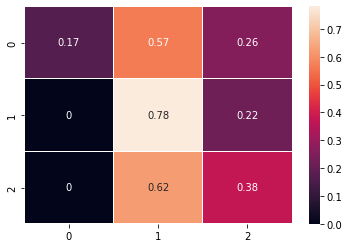

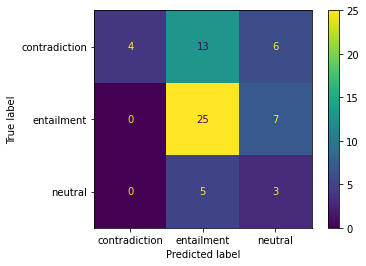

=>> The accuracy of the dataset cherry_dataset is 0.5079365079365079
=>> The precision, recall and f_score are  (0.5896317829457365, 0.44338768115942023, 0.404320987654321)


In [74]:
"""
Code for adding the cherry-picked data to a separate dictionaty key named 'cherry_dataset'
"""
df = pd.read_csv('examples_df_pair_pos.csv')
cherry_ids = []
for elem in df['pos_pair']:
  txt = elem[1:len(elem)-1]
  sent = txt.split(',')
  sent[0] = sent[0].replace('\'', '')
  cherry_ids.append(sent[0])

SNLI['cherry_dataset'] = { pid: SNLI['train'][pid] for pid in cherry_ids}

In the test dataset there are 9824 probelms, 
 from which 0 can be transformed into trees 
 and for 9824 we have used the baseline system
=>> In the true labels there are =>> Counter({'entailment': 3368, 'contradiction': 3237, 'neutral': 3219})
=>> In the predicted labels there are =>> Counter({'entailment': 6369, 'neutral': 2960, 'contradiction': 495})


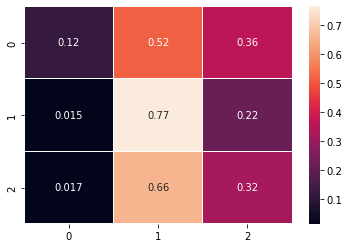

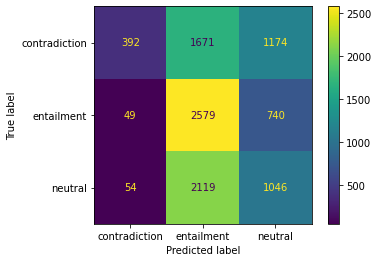

=>> The accuracy of the dataset test is 0.40889657980456023
=>> The precision, recall and f_score are  (0.5167425668721005, 0.4039272536945348, 0.35945769603639427)


In [71]:
"""
Level is an integer representing the systems level of complexity
0 - baseline
1 - tree only
2 - combination

SNLI_dataset_type can be : 
'test'
'sub_train'
'cherry_dataset'
"""
SNLI_dataset_type = 'test'
level = 0

system_statistics(SNLI_dataset_type, level)